In [15]:
pip install mtcnn


#For implementing this project I have gone through the following steps:

1. Detect the face in the image using the mtcnn face detector
2. Feed the detected face to FaceNet model in order to obtain the embeddings for the face. It returns a 128 dimensional vector.
3. Feed the 128-dimensional vector to an SVM classifier determine the identity of the detected face


In [16]:
from keras.models import load_model
import mtcnn
from mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score
from matplotlib.patches import Rectangle

# Face Detection:

In the first step, the image is read and as I have used OpenCV the image is imported in BGR format. As a result, I convert the image to RGB format first. Then the image is fed to the mtcnn network which outputs the coordinates of the bounding boxes surrounding the faces in the input image. It also gives the facial landmarks for the detected faces.

Using the coordinates of the bounding boxes, I extract the face images from the input image.

These face images should be fed to the FaceNet model for feature extraction. In order to use the FaceNet network, the input image should be of size 160 x 160 x3. Consequently, before feeding the face images to the network I upscale the face images to 160 by 160.

In [17]:
def face_detection(img_path):
  faces=[]
  boxes_properties=[]
  img = cv2.imread(img_path,1) # 1:Loads a color image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Create a detector
  detector=MTCNN()
  # detect faces in the image
  results = detector.detect_faces(img)# results is a list all of all the returned bounding boxes, each element of the list is a library indicating some information about the bounding box
  #returns the coordinates of the bottom-left corner of the bounding box,width,heigh
  for result in results:
    # extract the bounding box from the first face(In the case that there are several people in an image)
    x1, y1, width, height = result['box']
    # bug fix()
    x1, y1 = abs(x1), abs(y1) # fix the bug when x1 or y1 are negative!
    x2, y2 = x1 + width, y1 + height
    # return the coordinates of the bounding box
    boxes_properties.append([x1,y1,width,height])
    # extract the face
    face = img[y1:y2, x1:x2]
    # Resize the face for feeding it to the FaceNet model
    face = cv2.resize(face, (160,160))
    faces.append(face) 
  return faces,boxes_properties

#load_faces function:

This function loads the images and extracts faces for all the images in the specified directory. The directory for this function is a path like: 
'schitts_creek_5_characters/train/Johnny'

In [18]:
# load images and extract faces for all images in a directory
def load_faces(directory):
  faces=[]
  # enumerate files
  for filename in listdir(directory):
    #path
    path=directory+'/'+filename
    # get face
    face=face_detection(path)[0][0]# The first zero determines that the "faces" output is considered. The second zero is  for situations that the face_detction function returns more than one bounding box
    # store
    faces.append(face)
  return faces# A list of numpy arrays

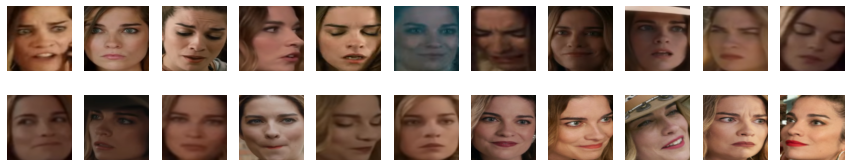

In [19]:
out=load_faces('/content/drive/MyDrive/Face recognition/Schitts_creek_5_characters/train/Alexis')
plt.figure(figsize=(15,3))
for i in range(1,23):# there are 22 images of Alexis in train/Alexis folder and I want to display all of them.
  plt.subplot(2,11,i)
  plt.axis('off') 
  plt.imshow(out[i-1])


#load_dataset function:

The load_dataset() function below takes a directory name such as ‘schitts_creek_5_characters/train‘, detects faces for each subdirectory (celebrity) and assigns labels to each detected face based on the folder in which the image existed. The folders are named as: Johnny, Moira, David, Alexis and Roland.

In [20]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory+'/'+ subdir
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for i in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)  #A list
		y.extend(labels) #A list
	return np.array(X), np.array(y)

The schitts_creek_5_characters dataset contains 3 folders: train, validation and test. In the train and validation folders there are some solo photos of each character, while in the test folder, the images contain more than one  character. I load the images from train and validation folders and create train set and val set for the future use. I go through each of the images (all of the characters in the train and val folder), detect the faces in each image and assign the suitable label to that face image.The SVM classifier that I am going to use, is trained using train set, so it will be abale to determine the identity of each of these 5 characters in any given images.

In [21]:
# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/Face recognition/Schitts_creek_5_characters/train')
print(trainX.shape, trainy.shape)
# load the validation dataset
valX, valy = load_dataset('/content/drive/MyDrive/Face recognition/Schitts_creek_5_characters/validation')
print(valX.shape, valy.shape)

# save arrays to one file in compressed format
np.savez_compressed('Schitts_creek_5_characters.npz', trainX, trainy, valX, valy)
#numpy.savez_compressed(file, *args, **kwds)
#ave several arrays into a single file in compressed .npz format.
#If keyword arguments are given, then filenames are taken from the keywords. If arguments are passed in with no keywords, then stored filenames are arr_0, arr_1, etc.

>loaded 19 examples for class: David
>loaded 21 examples for class: Moira
>loaded 16 examples for class: Roland
>loaded 26 examples for class: Johnny
>loaded 22 examples for class: Alexis
(104, 160, 160, 3) (104,)
>loaded 7 examples for class: Johnny
>loaded 7 examples for class: Alexis
>loaded 7 examples for class: Moira
>loaded 7 examples for class: Roland
>loaded 7 examples for class: David
(35, 160, 160, 3) (35,)


To avoid repeating the above steps every time, I save the trainX,trainy,valX, valy, testX and testy as a zip file which can be used later.

#5.FaceNet model:

In [22]:
# load the face dataset
data = np.load('Schitts_creek_5_characters.npz')
trainX, trainy, valX, valy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, valX.shape, valy.shape)

Loaded:  (104, 160, 160, 3) (104,) (35, 160, 160, 3) (35,)





I have used a pre-trained keras model provided by [Hiroki Taniai](https://github.com/nyoki-mtl/keras-facenet/blob/master/README.md). The model was traiened on MS-Celeb-1M dataset. It extracts the embeddings from the face images and it expects input images to be :

1.  color(RGB)
2.  have their pixel values standardized across all three channels
3.  have a square shape of 160×160 pixels


In [23]:
# load the facenet model
model = load_model('/content/drive/My Drive/Face recognition/model/facenet_keras.h5')
print(model.inputs)
print(model.outputs)
print('Loaded Model')

[<tf.Tensor 'input_1_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]
Loaded Model


#get_embedding function:


In order to feed an image to the FaceNet model we should preprocess it in a way that the pixel values be standardized.The first and last conditions have been already met.( RGB values, size:160x160 )

In [24]:
# This function returns the embedding of the input face
def get_embedding(face, model):
  # standardize the pixel values
  face=face.astype('float32')
  mean, std=np.mean(face), np.std(face)
  face=(face-mean)/std
  # add to the dimension of the image
  face= np.expand_dims(face, axis=0) # the input to the FaceNet should be of shape (None,160,160,3) 
  # get the embedding of the face
  embedding=model.predict(face)
  return embedding[0]


In [25]:
# convert each face in training set to embedding
face_embedding_train=[]
for face in trainX:
  feature=get_embedding(face,model)
  face_embedding_train.append(feature)
face_embedding_train=np.array(face_embedding_train)
print(face_embedding_train.shape)

# convert each face in test set to embedding
face_embedding_val=[]
for face in valX:
  feature=get_embedding(face,model)
  face_embedding_val.append(feature)
face_embedding_val=np.array(face_embedding_val)
print(face_embedding_val.shape)


(104, 128)
(35, 128)


In [26]:
print("face_embedding_train shape:",face_embedding_train.shape)
print("train_labels shape:",trainy.shape)
print("face_embedding_val shape:",face_embedding_val.shape)
print("val_labels shape:",valy.shape)


face_embedding_train shape: (104, 128)
train_labels shape: (104,)
face_embedding_val shape: (35, 128)
val_labels shape: (35,)


# Training the classifier:

Using the embeddings obtained from the FaceNet model, I train an SVM classifier. I set the probability= True as I want to know how much the classifier is confident about its prediction for different faces.

In [27]:
#Applying classifier to data
clf = svm.SVC(kernel='linear',probability=True)
clf.fit(face_embedding_train, trainy)
prediction=clf.predict(face_embedding_val)

In [28]:
accuracy_score(valy,prediction)

1.0

 I have obtained 100% accuracy on the validation set which includes the solo photos of characters.

#Testing our model on unseen data:

In this part, I test the model on some images that have multiple characters. These images are loaded from the test folder in the dataset.

In the plot_detected_faces at first, the image is read and converted to RGB for the purpose of plotting the input image. In the next step, the face_detection function is called to detect the faces in the image and and it outputs the face images and the bounding boxes surrounding the faces. Next, for each of the detected faces the get_embedding funtion is run to output the feature vector of the face. Finally the embdding is fed to the SVM classifier to determine the identity of the person.

I have considered a condition by which I remove the predictions with confidence less than 50%. At the end I plot the bounding boxes with their respective labels on each input image.

In [29]:
def plot_detected_faces(directory, model):
  img = cv2.imread(directory,1) # 1:Loads a color image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  ax=plt.gca()
  faces,boxes=face_detection(directory)
  for i in range(0,len(faces)):
    feature= get_embedding(faces[i], model)
    label=clf.predict(np.expand_dims(feature, axis=0))
    score=clf.predict_proba(np.expand_dims(feature, axis=0))
    if(np.max(score)>0.5):
      x1,y1=boxes[i][0],boxes[i][1]
      width,height=boxes[i][2],boxes[i][3]
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')        #create object rect, (x1,y1): the bottom and left corner coordinate
      # draw the box
      ax.add_patch(rect)
      plt.text(x1, y1, "{} {:.2f}".format(label, np.max(score)), color='white')    # add a text to a specific point on the image
      ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False,labelleft=False)
  plt.show()
    

In the following function I load all the samples from the test folder and call the plot_detected_faces to show the pictures and the detected faces.

In [30]:
def load_faces_test(directory, model):
  faces=[]
  # load the images in the test files
  for subdir in listdir(directory):
    for filename in listdir(directory+'/'+subdir):
     #path
     path=directory+'/'+subdir+'/'+filename
     img = cv2.imread(path,1) # 1:Loads a color image
     plot_detected_faces(path,model)
     

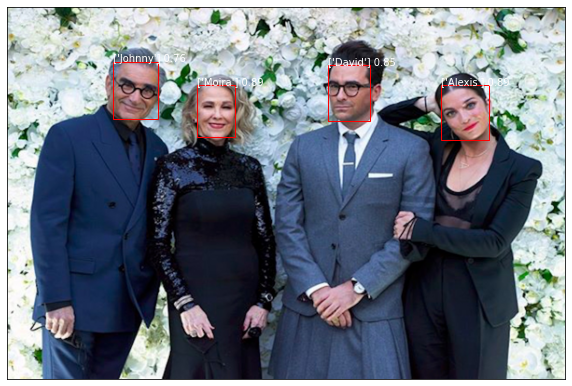

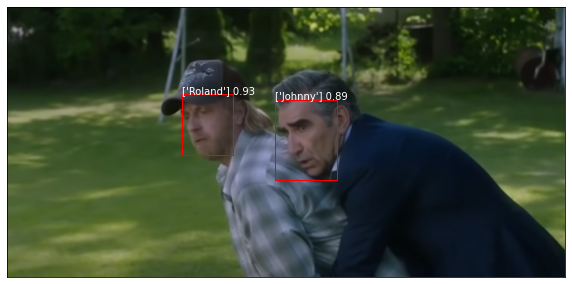

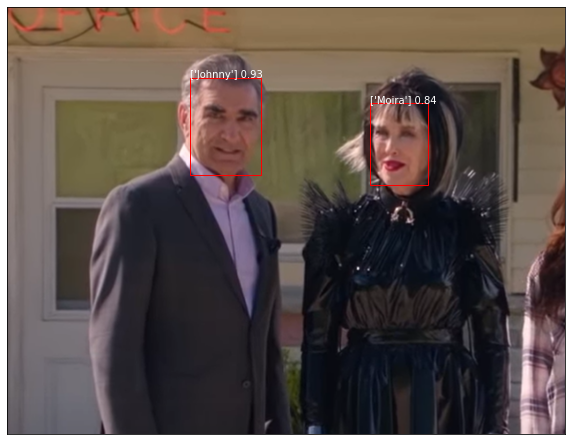

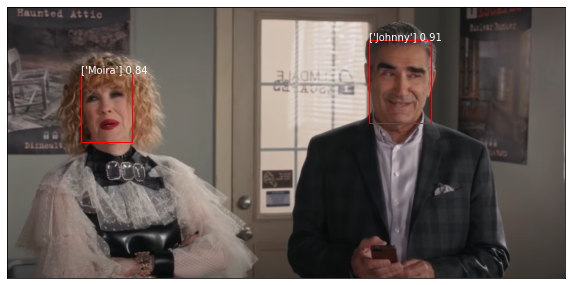

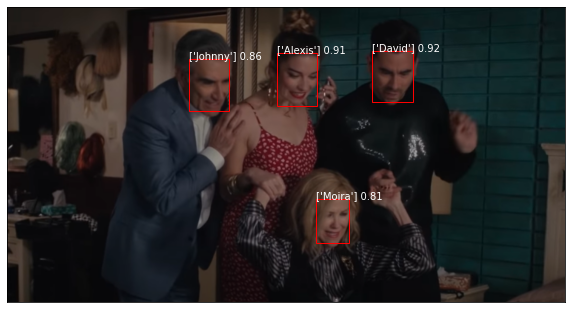

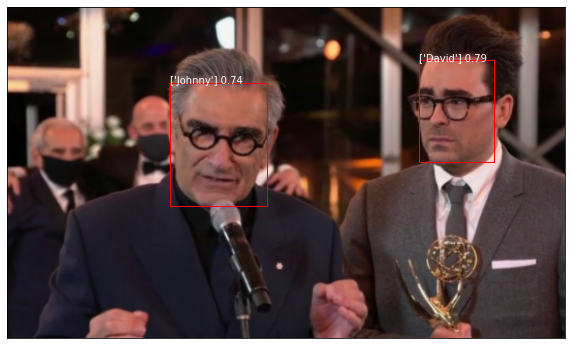

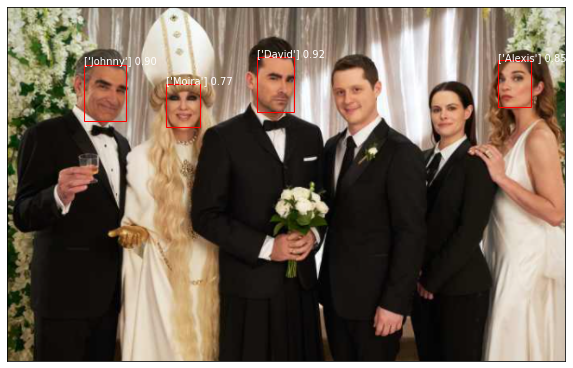

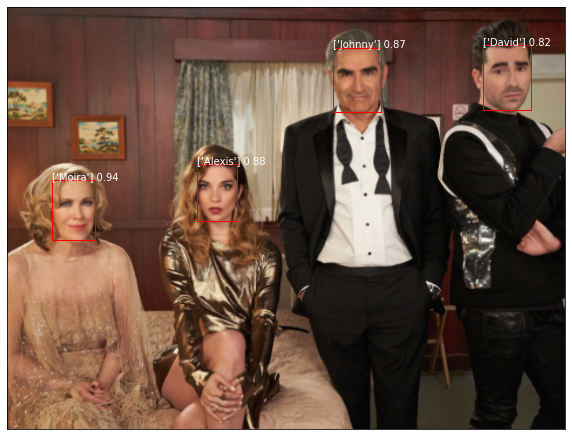

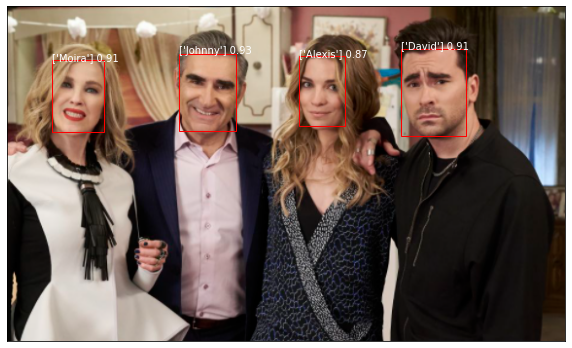

In [31]:
load_faces_test('/content/drive/MyDrive/Face recognition/Schitts_creek_5_characters/test', model)

In [ ]:
0